# Estimación de ruido mediante análisis del histograma

In [1]:
import numpy as np
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm

%load_ext autoreload
%autoreload 2
%matplotlib inline

Leemos la data extraida del slice

In [2]:
data_path = 'infosaves'
with open(rf"infosaves/100.0_100.0_253x263.json") as f:
    stats = json.load(f)
stats

{'nombre_img': '100.0_100.0_253x263',
 'altura': 253,
 'width': 263,
 'varianza': 148.0590359989778,
 'mean': 15.669892844797788}

### Reconstruimos el ruido con media y varianza

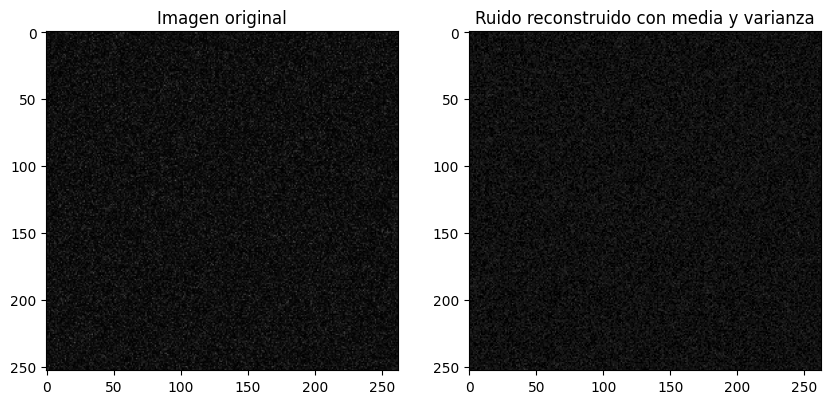

In [7]:
ruido_real = cv2.imread('PAIByB-1/Noise-1.tif', cv2.IMREAD_GRAYSCALE)
ruido_corte = ruido_real[:stats['altura'], :stats['width']]
ruido_reconstruido = np.random.normal(loc=stats['mean'], 
                                      scale=np.sqrt(stats['varianza']),
                                      size=(stats['altura'], stats['width']))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ruido_corte, vmin=0, vmax=255, cmap='gray')
axs[0].set_title('Imagen original')
axs[1].imshow(ruido_reconstruido, vmin=0, vmax=255, cmap='gray')
axs[1].set_title('Ruido reconstruido con media y varianza')
plt.show()

### Ahora, con el histograma

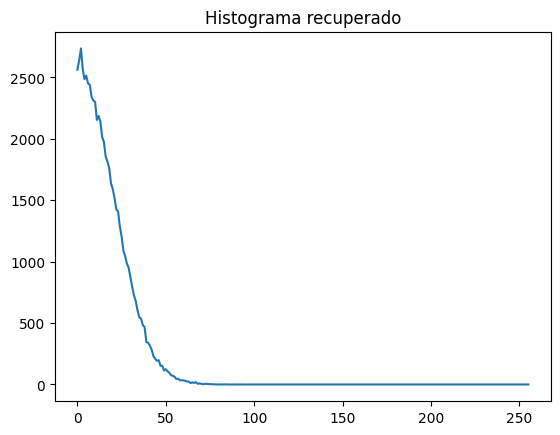

In [9]:
hist_df = pd.read_csv(f"infosaves/hist100.0_100.0_253x263.csv")

fig, ax = plt.subplots()
ax.plot(hist_df['gray_lvl'], hist_df['hist_value'])
ax.set_title('Histograma recuperado')
plt.show()

### Ajustamos una distribución normal por análisis estadístico del histograma

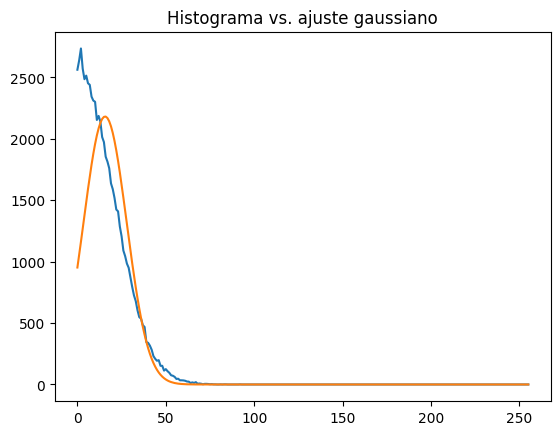

In [10]:
I, h = hist_df['gray_lvl'], hist_df['hist_value']
mu = np.dot(I, h) / h.sum()
sigma = np.sqrt(np.dot((I - mu)**2, h) / h.sum())
bell_curve = norm.pdf(x=I, loc=mu, scale=sigma) * h.sum()

fig, ax = plt.subplots()
ax.plot(hist_df['gray_lvl'], hist_df['hist_value'])
ax.plot(hist_df['gray_lvl'], bell_curve)
ax.set_title('Histograma vs. ajuste gaussiano')
plt.show()

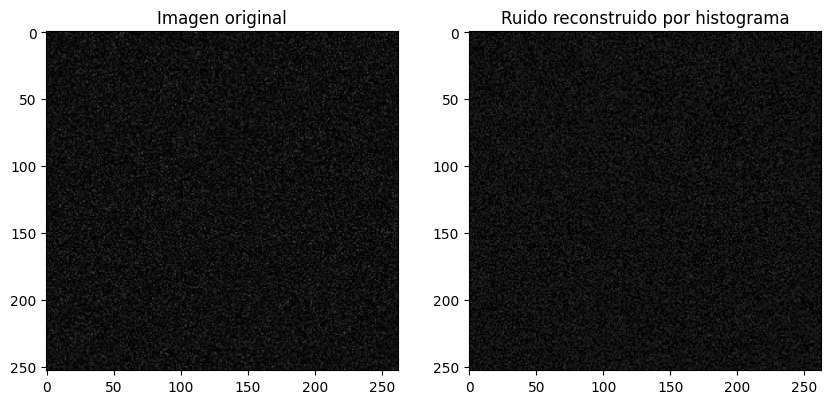

In [13]:
ruido_rec_hist = np.random.normal(loc=mu, 
                                  scale=sigma,
                                  size=(stats['altura'], stats['width']))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ruido_corte, vmin=0, vmax=255, cmap='gray')
axs[0].set_title('Imagen original')
axs[1].imshow(ruido_rec_hist, vmin=0, vmax=255, cmap='gray')
axs[1].set_title('Ruido reconstruido por histograma')
plt.show()

In [11]:
# Calculo DMA
dma = np.abs(I - mu).dot(h) / h.sum()
print(f"{dma=:.3f}")

dma=9.750
